# LSTM_model4

LSTM_model1 uses a simple layer of LSTM with N=100 times steps, Nh=150 hidden units and two input features to take the gain parameter of the amplifier into account.
Dataset can be downloaded in http://www.montefiore.ulg.ac.be/services/acous/STSI/downloads.php

In [1]:
#### !/usr/bin/python
# -*- coding: utf-8 -*-
"""lstm for guitar signal"""
import os
import sys
sys.path.append('Codes')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from dataShapingGain import *
from savePerf import *
import scipy.io.wavfile
import time
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import *
from saveTransformedGraph import optimizeGraph

modelName = "LSTM_model4"

#############################
# Directory experiment
#############################
date = time.strftime("%Y-%m-%d-%H-%M")
path = os.path.join("Experiments",date)
if not os.path.isdir(path):
    os.makedirs(path)
    #experiment/"date"/temp will contain the backuped model parameters
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
    # if you run the file two time in a minute
else :
    date = date+'(2)'
    path = os.path.join("Experiments",date)
    os.makedirs(path)
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)

# directory that will contain tensorboard information
pathLog = 'Tf_logs'
if not os.path.isdir(pathLog):
    os.makedirs(pathLog)
pathLog = "{}/run-{}/".format(pathLog,date)

version = tf.__version__
print ("version {} of tensorflow".format(version))

#############################
# Model parameters
#############################
trainTestRatio = 0.8
maxSize = 0
num_step = 100
num_hidden = 150
num_out = 1
num_feature = 2
batch_size = 1000
num_epoch = 1000                                  
trainDuration = 60*60*15                            
                                      
amplifierName = 'EnglDisto_Gain1Gain5'
fileNameTrain = 'Datasets/training'+amplifierName+'.mat'             

fileNameValidation = 'Datasets/valEnglDisto.mat'

#############################
# Loading data
#############################
matrix = sio.loadmat(fileNameTrain)
matrixTrain = matrix['train']
fileNameTestGain1 = 'Datasets/testEnglDisto_Gain1.mat' # dataset validation path
matrix = sio.loadmat(fileNameTestGain1)
matrixTestGain1 = matrix['test']
fileNameTestGain5 = 'Datasets/testEnglDisto_Gain5.mat' # dataset validation path
matrix = sio.loadmat(fileNameTestGain5)
matrixTestGain5 = matrix['test']

if maxSize ==0:
    maxSize = len(matrixTrain)
    print("maxSize = {}".format(maxSize))
train_input,train_output = loadInputOutputGain2(matrixTrain[:maxSize],num_step)

numTrain = maxSize
numTestGain1 = len(matrixTestGain1)
numTestGain5 = len(matrixTestGain5)
print ("NumTrain: {}, NumTest:{}".format(numTrain,numTestGain1))

#######################
# Graph Construction
#######################
G = tf.Graph()
with G.as_default():
    with tf.name_scope("placeHolder"):
        data = tf.placeholder(tf.float32, [None, num_step,num_feature], name ="data") 
        target = tf.placeholder(tf.float32, [None, num_out],name = "target") 
        dataShaped = tf.transpose(data,[1,0,2])
    
    with tf.name_scope("LSTMLayer"):
        fusedCell = tf.contrib.rnn.LSTMBlockFusedCell(num_hidden,use_peephole=False)
        val, state = fusedCell(dataShaped,dtype=tf.float32) 
        
    with tf.name_scope("extractLastCelloftheLSTMLayer"):
        last_index = tf.shape(val)[0] - 1
        lastState = tf.gather(val,last_index)#[minibatchsize,num_hidden]
    
    prediction = fully_connected(lastState,int(target.get_shape()[1]),activation_fn=tf.nn.tanh,weights_regularizer=None,scope="FCPred")
    
##############################
# Cost function
##############################
    MSE = tf.reduce_mean(tf.square(prediction-target))
    EnergyTarget = tf.reduce_mean(tf.square(target)) 
    optimizer = tf.train.AdamOptimizer()
    minimize = optimizer.minimize(MSE)
    # Create summary view for tensorboard
    mse_summary = tf.summary.scalar('RMSE',tf.sqrt(MSE))
    summary_op = tf.summary.merge_all()
    #Create an init op to initialize variable
    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver() # save variable, use saver.restore(sess,"date/tmp/my_model.ckpt") instead of sess.run(init_op)

##############################
# Graph Execution
##############################
   
with tf.Session(graph=G) as sess:
    sess.run(init_op)
    train_writer = tf.summary.FileWriter(pathLog+'train',graph =tf.get_default_graph())
    test_writer = tf.summary.FileWriter(pathLog+'test')
    no_of_batches = int(np.floor((numTrain)/batch_size)) 
    no_of_batchesTestGain1 = int(np.floor((numTestGain1)/batch_size))
    no_of_batchesTestGain5 = int(np.floor((numTestGain5)/batch_size))
    tStart = time.clock()
    epoch =0
    NRMSETestGain1 = 1
    bestNRMSETestGain1 = 10  
    NRMSETestGain5 = 1
    bestNRMSETestGain5 = 10
     # train until the number of epoch or the training time is reached
    for epoch in range(num_epoch):
        tEpoch = time.clock()
        if (time.clock()-tStart < trainDuration) :
            ptr = 0
            if epoch % 20==0 : # each twenty epochs save the model
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myGraph.pb',as_text=False)
                save_path = saver.save(sess,os.path.join(pathTemp,'myModel.ckpt'))
            ############
            # Training #
            ############ 
            pMSETrain=0
            pEnergyTarget=0
            numBatchEff=0
            for j in range(no_of_batches):           
                inp, out = train_input[ptr:ptr+batch_size],train_output[ptr:ptr+batch_size]
                ptr+=batch_size
                numBatchEff+=1

                if j % np.floor(numTrain/numTestGain1) ==0 : # This is to have a train summary and a test summary of the same size
                    _,summary_str,pMSETrainTemp,pEnergyTargetTemp = sess.run([minimize,summary_op,MSE,EnergyTarget],{data: inp, target: out})
                    pMSETrain += pMSETrainTemp
                    pEnergyTarget += pEnergyTargetTemp
                    step = epoch*no_of_batches+j
                    # save the training RMSE for tensorboard
                    train_writer.add_summary(summary_str,step)                   
                else :
                    _,pMSETrainTemp,pEnergyTargetTemp = sess.run([minimize,MSE,EnergyTarget],{data: inp, target: out})
                    pMSETrain += pMSETrainTemp
                    pEnergyTarget += pEnergyTargetTemp
            # compute an estimation of the RMSE for this epoch       
            MSETrain = pMSETrain/numBatchEff
            EnergyTargetTrain = pEnergyTarget/numBatchEff
            NRMSETrain = np.sqrt(MSETrain/EnergyTargetTrain)
            print ("Epoch -{} calculated in {:5.2f} s ".format(epoch,time.clock()-tEpoch))
         
            #################
            # Testing Gain1 #
            #################
            pMSE = 0
            pEnergyTarget = 0
            numBatchEff=0 # count the number of minibatches since some of them are too short they are droped
            ptr2=0 
            test_input,test_output = loadInputOutputGain2(matrixTestGain1,num_step)    
            for k in range(no_of_batchesTestGain1):            
                inptest, outptest = test_input[ptr2:ptr2+batch_size],test_output[ptr2:ptr2+batch_size]                
                pMSETemp,pEnergyTargetTemp,summary_str = sess.run([MSE,EnergyTarget,summary_op],{data: inptest , target: outptest})
                pMSE += pMSETemp
                ptr2 += batch_size
                pEnergyTarget+=pEnergyTargetTemp
                step = epoch*no_of_batchesTestGain1+k
                test_writer.add_summary(summary_str,step*np.floor(numTrain/len(test_input)))
                numBatchEff+=1
                
            MSETest = pMSE/numBatchEff
            EnergyTargetTest = pEnergyTarget/numBatchEff
            NRMSETestGain1 = np.sqrt(MSETest/EnergyTargetTest)
            if NRMSETestGain1<bestNRMSETestGain1:
                bestNRMSETestGain1=NRMSETestGain1
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myBestGraph.pbtxt',as_text=True)
                save_path = saver.save(sess,os.path.join(pathTemp,'myBestModel.ckpt'))
            print("Epoch {}, NRMSE Test gain1/best: {:.5f}/{:.5f}, Training NRMSE: {:.5f}, deviation of {:.2f}%".format(epoch,NRMSETestGain1,bestNRMSETestGain1,NRMSETrain,100*np.sqrt((NRMSETrain-NRMSETestGain1)**2)/NRMSETrain))
            
            #################
            # Testing Gain5 #
            #################
            pMSE = 0
            pEnergyTarget = 0
            numBatchEff=0 # count the number of minibatches since some of them are too short they are droped
            ptr2=0
            test_input,test_output = loadInputOutputGain2(matrixTestGain5,num_step)
            for k in range(no_of_batchesTestGain5):                     
                inptest, outptest = test_input[ptr2:ptr2+batch_size],test_output[ptr2:ptr2+batch_size]                
                pMSETemp,pEnergyTargetTemp,summary_str = sess.run([MSE,EnergyTarget,summary_op],{data: inptest , target: outptest})
                pMSE += pMSETemp
                ptr2 += batch_size
                pEnergyTarget+=pEnergyTargetTemp
                step = epoch*no_of_batchesTestGain5+k
                test_writer.add_summary(summary_str,step*np.floor(numTrain/len(test_input)))
                numBatchEff+=1
                
            MSETest = pMSE/numBatchEff
            EnergyTargetTest = pEnergyTarget/numBatchEff
            NRMSETestGain5 = np.sqrt(MSETest/EnergyTargetTest)
            if NRMSETestGain5<bestNRMSETestGain5:
                bestNRMSETestGain5=NRMSETestGain5
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myBestGraph.pbtxt',as_text=True)
                save_path = saver.save(sess,os.path.join(pathTemp,'myBestModel.ckpt'))
            print("Epoch {}, NRMSE Testgain5/best: {:.5f}/{:.5f}, Training NRMSE: {:.5f}, deviation of {:.2f}%".format(epoch,NRMSETestGain5,bestNRMSETestGain5,NRMSETrain,100*np.sqrt((NRMSETrain-NRMSETestGain5)**2)/NRMSETrain))
                     
                
        else : break # break the while loop if number of epoch is reached
    tStop = time.clock()
    trainTime = time.strftime("%d:%H:%M:%S ", time.gmtime(tStop-tStart))
    
    ################################################################
    # Save Graph variable and information about the running session
    ################################################################
    # save graph model
    tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myFinalGraph.pbtxt',as_text=True)
    # Save checkpoint variables
    save_path = saver.save(sess,os.path.join(pathTemp,'myFinalModel.ckpt'))
    print ("Training duration {}".format(trainTime))
    totalParameters =np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()])
    print("Number of training variable {}".format(totalParameters))
    # log
    infoLog={}
    infoLog["path"] = path
    infoLog["MSE"] = bestNRMSETestGain5
    infoLog["num_step"] = num_step
    infoLog["num_hidden"] = num_hidden
    infoLog["num_epoch"] = epoch
    infoLog["batch_size"] = batch_size
    infoLog["maxSize"] = maxSize
    infoLog["duration"] = trainTime
    infoLog["totalParameters"] = totalParameters
    infoLog["version"] = version
    infoLog["n_layer"] = 1
    infoLog["trainDropout"] = 0
    infoLog["nameModel"] = modelName
    infoLog["conv_chan"] = [0]
    infoLog["strides"] = 0
    infoLog["conv_size"] = 0
    infoLog["amplifierName"]=amplifierName
    logPerf(infoLog)
    input_nodes=["placeHolder/data"]
    output_nodes=["FCPred/Tanh"]
    optimizeGraph(pathTemp,input_nodes,output_nodes) 
    
    ################################################
    #   Validation
    ################################################
    restorePath = os.path.join(pathTemp,'myBestModel.ckpt') # restore the best model
    saver.restore(sess,restorePath)
    matrixVal = sio.loadmat(fileNameValidation)
    matrixVal = matrixVal['val']  
    valSize = 6*44100
    if valSize == 0 :
        valSize = len(matrixVal)
    # shape validation testpLast
    val_input,val_output = loadValidationGain(matrixVal,num_step,valSize)
    lPrediction = []
    lTarget = []
    ptr3 = 0
    no_of_batchesVal = int(np.floor((len(val_input))/batch_size))
    for k in range(no_of_batchesVal):
        pPrediction,pTarget = sess.run([prediction,target],{data: val_input[ptr3:ptr3+batch_size], target: val_output[ptr3:ptr3+batch_size]}) 
        lPrediction.append(pPrediction)
        lTarget.append(pTarget)   
        ptr3+=batch_size
    #plt.show()scree
    predictionArray = np.array(lPrediction,dtype=np.float32).ravel()
    targetArray = np.array(lTarget,dtype=np.float32).ravel()
    scipy.io.wavfile.write(os.path.join(path,'prediction.wav'),44100,predictionArray)
    scipy.io.wavfile.write(os.path.join(path,'target.wav'),44100,targetArray)

    # save emulation in a pickle format
    ax = plt.subplot(111)
    ax.plot(predictionArray[6000+2*num_step:6700+2*num_step],label='prediction')
    ax.plot(targetArray[6000+2*num_step:6700+2*num_step],label='target')
    ax.legend()
    plt.xlabel('sample n')
    plt.ylabel('Amplitude y[n]')
    nameFigEstimation = os.path.join(path,"targetVsPrediction.pickle")
    pickle.dump(ax,open(nameFigEstimation, 'wb'))
print ("done, good job kids")


version 1.13.1 of tensorflow
maxSize = 13452814
NumTrain: 13452814, NumTest:1681603
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch -0 calculated in 455.64 s 
Epoch 0, NRMSE Test gain1/best: 2.73035/2.73035, Training NRMSE: 0.51328, deviation of 431.94%
Epoch 0, NRMSE Testgain5/best: 0.79332/0.79332, Training NRMSE: 0.51328, deviation of 54.56%
Epoch -1 calculated in 456.44 s 
Epoch 1, NRMSE Test gain1/best: 2.08264/2.08264, Training NRMSE: 0.46199, deviation of 350.80%
Epoch 1, NRMSE Testgain5/best: 0.76480/0.76480, Training NRMSE: 0.46199, deviation of 65.54%
Epoch -2 calculated in 459.60 s 
Epoch 2, NRMSE Test gain1/best: 1.68018/1.68018, Training NRMSE: 0.43188, deviation of 289.04%
Epoch 2, NRMSE Testgain5/best: 0.70920/0.70920, Training NRMSE: 0.43188, deviation of 64.21%
Epoch -3 calculated in 459.33 s 
Epoch 3, NRMSE Test gain1/best: 1.22085/1.22085, Training NRMSE: 0.41061, deviation of 197.33%
Epoch 3, NRMSE Testgain5/best: 0.69498/0.69498, Training NRMSE: 0.41061, deviation of 69.26%
Epoch -4 calculated in 458.86 s 
Epoch 4, NRMSE Test gain1/best: 1.09728/1.09728, Training NRMSE: 0.40258, deviation

Epoch -37 calculated in 459.04 s 
Epoch 37, NRMSE Test gain1/best: 0.43822/0.43822, Training NRMSE: 0.35599, deviation of 23.10%
Epoch 37, NRMSE Testgain5/best: 0.45218/0.45166, Training NRMSE: 0.35599, deviation of 27.02%
Epoch -38 calculated in 458.72 s 
Epoch 38, NRMSE Test gain1/best: 0.44748/0.43822, Training NRMSE: 0.35519, deviation of 25.98%
Epoch 38, NRMSE Testgain5/best: 0.47206/0.45166, Training NRMSE: 0.35519, deviation of 32.90%
Epoch -39 calculated in 458.70 s 
Epoch 39, NRMSE Test gain1/best: 0.44379/0.43822, Training NRMSE: 0.35469, deviation of 25.12%
Epoch 39, NRMSE Testgain5/best: 0.48990/0.45166, Training NRMSE: 0.35469, deviation of 38.12%
Epoch -40 calculated in 459.26 s 
Epoch 40, NRMSE Test gain1/best: 0.43408/0.43408, Training NRMSE: 0.35456, deviation of 22.43%
Epoch 40, NRMSE Testgain5/best: 0.45436/0.45166, Training NRMSE: 0.35456, deviation of 28.15%
Epoch -41 calculated in 458.98 s 
Epoch 41, NRMSE Test gain1/best: 0.44038/0.43408, Training NRMSE: 0.35391,

Epoch -74 calculated in 458.22 s 
Epoch 74, NRMSE Test gain1/best: 1.28211/0.43408, Training NRMSE: 0.84873, deviation of 51.06%
Epoch 74, NRMSE Testgain5/best: 1.06886/0.41898, Training NRMSE: 0.84873, deviation of 25.94%
Epoch -75 calculated in 458.21 s 
Epoch 75, NRMSE Test gain1/best: 0.76108/0.43408, Training NRMSE: 0.79667, deviation of 4.47%
Epoch 75, NRMSE Testgain5/best: 0.90887/0.41898, Training NRMSE: 0.79667, deviation of 14.08%
Epoch -76 calculated in 459.01 s 
Epoch 76, NRMSE Test gain1/best: 1.07615/0.43408, Training NRMSE: 0.75241, deviation of 43.03%
Epoch 76, NRMSE Testgain5/best: 0.85011/0.41898, Training NRMSE: 0.75241, deviation of 12.98%
Epoch -77 calculated in 458.54 s 
Epoch 77, NRMSE Test gain1/best: 0.92331/0.43408, Training NRMSE: 0.67275, deviation of 37.25%
Epoch 77, NRMSE Testgain5/best: 0.80357/0.41898, Training NRMSE: 0.67275, deviation of 19.45%
Epoch -78 calculated in 458.79 s 
Epoch 78, NRMSE Test gain1/best: 0.88722/0.43408, Training NRMSE: 0.58296, 

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Experiments/2019-05-20-17-21/temp/myFinalModel.ckpt
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
INFO:tensorflow:Restoring parameters from Experiments/2019-05-20-17-21/temp/myBestModel.ckpt
done, good job kids


<IPython.core.display.Javascript object>


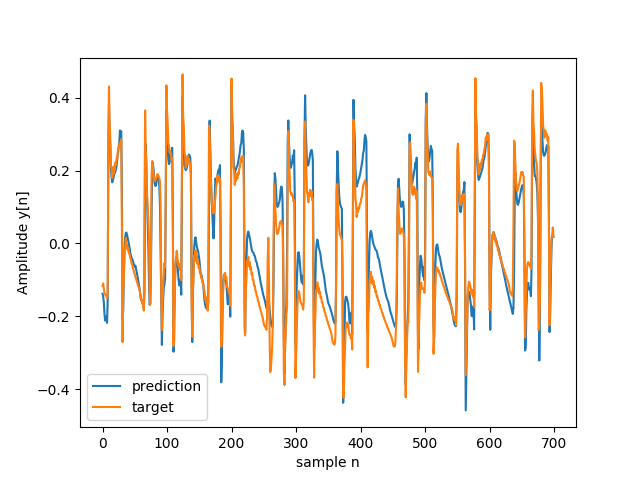

In [2]:
from show import *
%matplotlib notebook
showPickle(nameFigEstimation)

In [3]:
import numpy as np
import os
import sys
sys.path.append('Codes')
amplifierName = 'EnglDisto'
fileNameTrain = 'Datasets/training'+amplifierName+'.mat'             #dataset train/test path
fileNameTest = 'Datasets/test'+amplifierName+'.mat' # dataset validation path
fileNameValidation = 'Datasets/val'+amplifierName+'.mat'
maxSize = 44100
#############################
# Loading data
#############################
matrix = sio.loadmat(fileNameTrain)
matrixTrain=matrix['train']
matrixIn = matrixTrain[:maxSize,0]
matrixOut = matrixTrain[:maxSize,1]
matrixParameters = matrixTrain[:maxSize,2]
my_indices = np.arange(len(matrixIn)-(num_step-1)) # all indices - numstep
indices = (np.arange(num_step) +my_indices[:,np.newaxis]) # each sequence of num_step decayed from one sample
trainInput = np.stack((np.take(matrixIn,indices),np.take(matrixParameters,indices)),axis=2) # [numsample,num_step,num_features]
trainOutput = np.reshape(matrixOut[num_step-1:],(len(matrixIn)-(num_step-1),1))
def shuffleMatrix(data):
    np.random.seed(42)
    print(len(data))
    shuffled_indices = np.random.permutation(len(data))
    return [data[i] for i in shuffled_indices]
shuffled = shuffleMatrix(trainInput)
print(trainInput[0])
shuffled[0]

44001
[[ 1.46697998e-01  5.00000000e+00]
 [ 1.42059326e-01  5.00000000e+00]
 [ 1.36627197e-01  5.00000000e+00]
 [ 1.30340576e-01  5.00000000e+00]
 [ 1.23748779e-01  5.00000000e+00]
 [ 1.17095947e-01  5.00000000e+00]
 [ 1.10443115e-01  5.00000000e+00]
 [ 1.03881836e-01  5.00000000e+00]
 [ 9.73815918e-02  5.00000000e+00]
 [ 9.09729004e-02  5.00000000e+00]
 [ 8.41674805e-02  5.00000000e+00]
 [ 7.74536133e-02  5.00000000e+00]
 [ 7.02209473e-02  5.00000000e+00]
 [ 6.32629395e-02  5.00000000e+00]
 [ 5.59387207e-02  5.00000000e+00]
 [ 4.93164062e-02  5.00000000e+00]
 [ 4.27551270e-02  5.00000000e+00]
 [ 3.71398926e-02  5.00000000e+00]
 [ 3.22875977e-02  5.00000000e+00]
 [ 2.83203125e-02  5.00000000e+00]
 [ 2.53295898e-02  5.00000000e+00]
 [ 2.28881836e-02  5.00000000e+00]
 [ 2.09045410e-02  5.00000000e+00]
 [ 1.90429688e-02  5.00000000e+00]
 [ 1.70593262e-02  5.00000000e+00]
 [ 1.48315430e-02  5.00000000e+00]
 [ 1.22375488e-02  5.00000000e+00]
 [ 9.46044922e-03  5.00000000e+00]
 [ 6.46972656e

array([[ 2.47192383e-02,  5.00000000e+00],
       [ 2.48718262e-02,  5.00000000e+00],
       [ 2.46582031e-02,  5.00000000e+00],
       [ 2.42614746e-02,  5.00000000e+00],
       [ 2.36816406e-02,  5.00000000e+00],
       [ 2.27355957e-02,  5.00000000e+00],
       [ 2.19116211e-02,  5.00000000e+00],
       [ 2.07214355e-02,  5.00000000e+00],
       [ 1.95922852e-02,  5.00000000e+00],
       [ 1.82495117e-02,  5.00000000e+00],
       [ 1.67541504e-02,  5.00000000e+00],
       [ 1.55029297e-02,  5.00000000e+00],
       [ 1.40075684e-02,  5.00000000e+00],
       [ 1.24816895e-02,  5.00000000e+00],
       [ 1.13830566e-02,  5.00000000e+00],
       [ 9.73510742e-03,  5.00000000e+00],
       [ 8.94165039e-03,  5.00000000e+00],
       [ 7.56835938e-03,  5.00000000e+00],
       [ 6.89697266e-03,  5.00000000e+00],
       [ 6.07299805e-03,  5.00000000e+00],
       [ 5.85937500e-03,  5.00000000e+00],
       [ 5.52368164e-03,  5.00000000e+00],
       [ 5.88989258e-03,  5.00000000e+00],
       [ 6.

In [4]:
import numpy as np
mat = np.arange(143000)
numstep = 51
batchsize = 333
numtest = len(mat)
no_of_batchesTest = int(np.floor(numtest/batchsize))
subsize= 6
index = 0
sizeSubTest = int(np.floor(no_of_batchesTest/subsize))
ptr2=0
for k in range(no_of_batchesTest):
    if k%np.ceil(no_of_batchesTest/subsize) == 0 : # divide no_of_batches in subsize subBatches
        print("ptrstart {}, ptrstop {}".format((sizeSubTest)*index*batchsize,batchsize*((sizeSubTest)*index+sizeSubTest)-1))
        index +=1
        ptr2=0
    if ((ptr2+batchsize) < batchsize*sizeSubTest-1):
        print("subbatchIndice: {}/{}".format(ptr2,ptr2+batchsize))
        ptr2+=batchsize
print("subsizeTest {}".format(sizeSubTest))

ptrstart 0, ptrstop 23642
subbatchIndice: 0/333
subbatchIndice: 333/666
subbatchIndice: 666/999
subbatchIndice: 999/1332
subbatchIndice: 1332/1665
subbatchIndice: 1665/1998
subbatchIndice: 1998/2331
subbatchIndice: 2331/2664
subbatchIndice: 2664/2997
subbatchIndice: 2997/3330
subbatchIndice: 3330/3663
subbatchIndice: 3663/3996
subbatchIndice: 3996/4329
subbatchIndice: 4329/4662
subbatchIndice: 4662/4995
subbatchIndice: 4995/5328
subbatchIndice: 5328/5661
subbatchIndice: 5661/5994
subbatchIndice: 5994/6327
subbatchIndice: 6327/6660
subbatchIndice: 6660/6993
subbatchIndice: 6993/7326
subbatchIndice: 7326/7659
subbatchIndice: 7659/7992
subbatchIndice: 7992/8325
subbatchIndice: 8325/8658
subbatchIndice: 8658/8991
subbatchIndice: 8991/9324
subbatchIndice: 9324/9657
subbatchIndice: 9657/9990
subbatchIndice: 9990/10323
subbatchIndice: 10323/10656
subbatchIndice: 10656/10989
subbatchIndice: 10989/11322
subbatchIndice: 11322/11655
subbatchIndice: 11655/11988
subbatchIndice: 11988/12321
subbatch